In [1]:
#Importing dependencies
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import plot_confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score
from sklearn.dummy import DummyRegressor, DummyClassifier
import matplotlib.pyplot as plt
import seaborn as sns 
from imblearn.pipeline import Pipeline as ImPipeline

import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/crashes_clean', index_col=[0])
df.head()

,RD_NO,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,ALIGNMENT,...,PRIM_CONTRIBUTORY_CAUSE,STREET_NO,STREET_DIRECTION,STREET_NAME,BEAT_OF_OCCURRENCE,NUM_UNITS,MOST_SEVERE_INJURY,INJURIES_TOTAL,LATITUDE,LONGITUDE
0,JF146223,02/16/2022 11:30:00 AM,15,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,REAR TO REAR,PARKING LOT,STRAIGHT AND LEVEL,...,DRIVING SKILLS/KNOWLEDGE/EXPERIENCE,4650,W,NORTH AVE,2533.0,2,NO INDICATION OF INJURY,0.0,41.909765,-87.743376
1,JF145979,02/16/2022 08:24:00 AM,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,SIDESWIPE SAME DIRECTION,FOUR WAY,STRAIGHT AND LEVEL,...,DRIVING SKILLS/KNOWLEDGE/EXPERIENCE,9301,S,COTTAGE GROVE AVE,633.0,2,NO INDICATION OF INJURY,0.0,41.725625,-87.604417
2,JF146627,02/16/2022 05:14:00 PM,30,OTHER,OTHER,RAIN,"DARKNESS, LIGHTED ROAD",TURNING,DIVIDED - W/MEDIAN (NOT RAISED),STRAIGHT AND LEVEL,...,FAILING TO YIELD RIGHT-OF-WAY,6431,S,PULASKI RD,823.0,3,NONINCAPACITATING INJURY,1.0,41.775961,-87.722545
3,JF155027,02/24/2022 06:01:00 PM,30,NO CONTROLS,NO CONTROLS,SNOW,"DARKNESS, LIGHTED ROAD",ANGLE,NOT DIVIDED,STRAIGHT AND LEVEL,...,FAILING TO YIELD RIGHT-OF-WAY,19,E,21ST ST,131.0,2,NO INDICATION OF INJURY,0.0,41.854146,-87.626206
4,JF151203,02/21/2022 09:29:00 AM,30,STOP SIGN/FLASHER,FUNCTIONING PROPERLY,FOG/SMOKE/HAZE,DAYLIGHT,ANGLE,NOT DIVIDED,STRAIGHT AND LEVEL,...,UNABLE TO DETERMINE,2000,E,70TH ST,331.0,2,NO INDICATION OF INJURY,0.0,41.768092,-87.576290


In [4]:
"""
Here I'm creating my train-test-split and setting my target variable. 
'PRIM_CONTRIBUTORY_CAUSE' is the target since we are looking for the possible cause
of accidents on the road in relation to the other columns

"""
X = df.drop('PRIM_CONTRIBUTORY_CAUSE', axis=1)
y = df['PRIM_CONTRIBUTORY_CAUSE']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=19651609)

In [5]:
categorical_columns= X.select_dtypes(include= 'object').columns
numeric_columns= X.select_dtypes(exclude= 'object').columns

In [6]:
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median", add_indicator=True)), ("scaler", StandardScaler())])

categorical_transformer = Pipeline(
    steps=[('imputer', SimpleImputer(strategy='most_frequent')), ('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_columns),
        ("cat", categorical_transformer, categorical_columns)])

Here I am instantiating and fitting a dummy classification model just to check out my odds against random chance. It's not really a necessary step, but I'm using this basic score as my baseline model accuracy. 

In [7]:
dummy = DummyClassifier()
dummy.fit(X_train, y_train)
dummy.score(X_train, y_train)

0.43105483035750347

In [8]:
dummy.score(X_test, y_test)

0.429688762048355

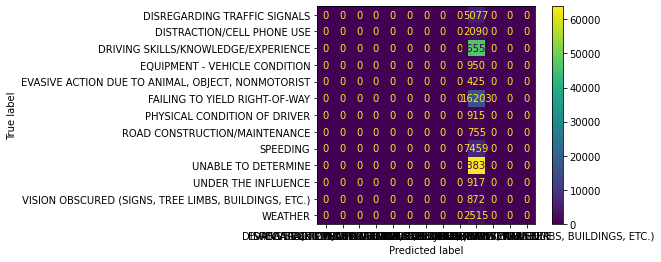

In [9]:
plot_confusion_matrix(dummy, X_test, y_test);

## Random Forest Iterations

In [ ]:
# Here I went on and balanced the classes as I know that an imbalance exists
# I want to get my basic rf score before gridsearching for comparisons sake
rf_model = Pipeline(steps=[('clean', preprocessor), ('rf', RandomForestClassifier(class_weight='balanced'))])
rf_model.fit(X_train, y_train)

print(f'This is the basic training score: {rf_model.score(X_train, y_train)}')
print(f'This is the basic testing score: {rf_model.score(X_test, y_test)}')

In [ ]:
rf_model = Pipeline(steps=[('clean', preprocessor), 
                           ('rf', RandomForestClassifier(class_weight='balanced'))])

parameters = {'rf__n_estimators': [50, 100, 150, 200]}

rf_gs = GridSearchCV(estimator=rf_model,
                 param_grid=parameters,
                 cv=5, error_score= 'raise')

rf_gs.fit(X_train, y_train)

print(f'This is the 1st grid search training score: {rf_gs.score(X_train, y_train)}')
print(f'This is the 1st grid search testing score: {rf_gs.score(X_test, y_test)}')
print(f"This is the 1st grid search's best parameters': {rf_gs.best_params_}")

In [ ]:
parameters = {'rf__max_samples_split': [2, 5, 10]}

rf_gs2 = GridSearchCV(estimator=rf_model,
                 param_grid=parameters,
                 cv=5, error_score= 'raise')

rf_gs2.fit(X_train, y_train)

print(f'This is the 2nd grid search training score: {rf_gs2.score(X_train, y_train)}')
print(f'This is the 2nd grid search testing score: {rf_gs2.score(X_test, y_test)}')
print(f"This is the 2nd grid search's best parameters': {rf_gs2.best_params_}")